Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import adam_v2
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# ignore this if you have already extracted the file in your drive
# tip: make a "shortcut" of "CNN_assignment.zip" on your G-drive so that it won't take your drive space and your internet to upload it. 
# import zipfile
# zip_path = "/content/gdrive/MyDrive/CNN_assignment.zip"
# extract = "/content/gdrive/MyDrive/"
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract)

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# make sure you mention the "correct pathname of your data."
# if you extracted .zip as it is, then you can directly run my code without a problem.  
main_path = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(main_path + "/Train")
data_dir_test = pathlib.Path(main_path + "/Test")
# to make sure you have a correct path name
print("data_dir_train: ", data_dir_train, "\ndata_dir_test: ", data_dir_test)

data_dir_train:  /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train 
data_dir_test:  /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# creating train dataset here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# creating validation dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
## for test set , creating only 1 batch
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [ ]:
type(test_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

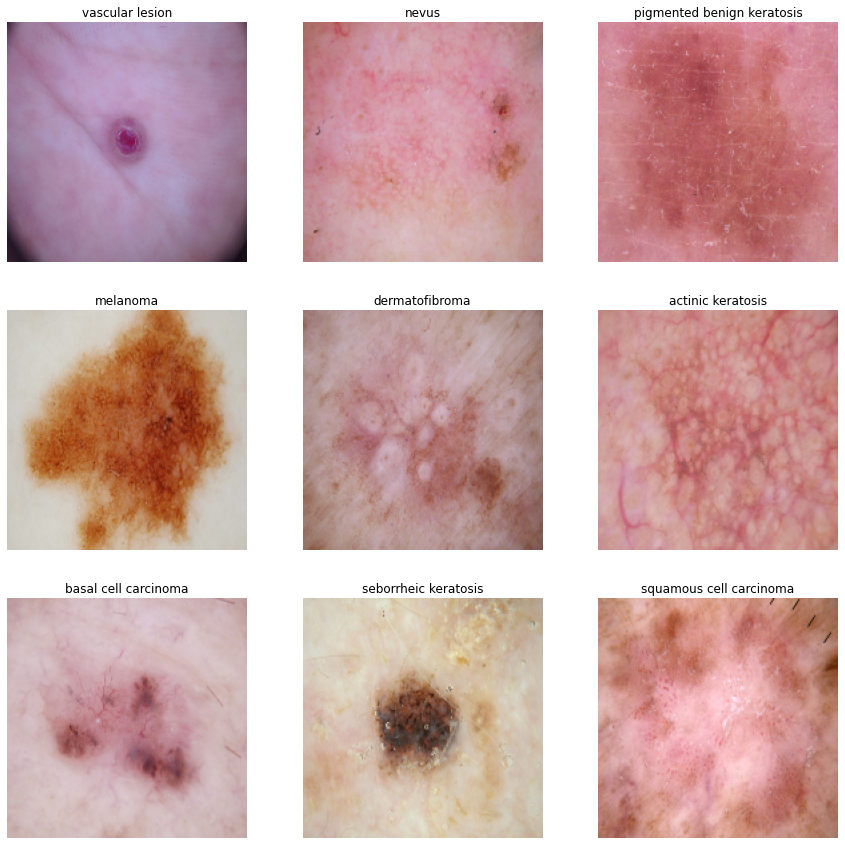

In [ ]:
plt.figure(figsize=(15, 15))
visited = []
visited_all = False
j = 0

for image, label in train_ds.take(50):
  if visited_all:
    break
  for i in range(len(class_names)):
    if len(visited) == 9:
      visited_all = True
      break
    if class_names[label[i]] in visited:
      continue
    else:
      ax = plt.subplot(3, 3, j+1)
      j+=1
      plt.imshow(image[i].numpy().astype('uint8'))
      plt.title(class_names[label[i]])
      plt.axis('off')
      visited.append(class_names[label[i]])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(type(train_ds), "\n", type(test_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 
 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
def model1():
  # create model
  model = Sequential()
  model.add(Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))

  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
    
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
#creating model1
model1 = model1()

In [ ]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 89, 89, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 32)        9248      
                                                        

In [ ]:
# Compile model
model1.compile(adam_v2.Adam(learning_rate = 0.0005), loss='SparseCategoricalCrossentropy', metrics=['accuracy', 'mse'])

### Train the model

In [ ]:
epochs = 20
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 269s 1s/step - loss: 2.0646 - accuracy: 0.1830 - mse: 18.0829 - val_loss: 2.0266 - val_accuracy: 0.2058 - val_mse: 18.4536
Epoch 2/20
56/56 [==============================] - 6s 106ms/step - loss: 1.9813 - accuracy: 0.2416 - mse: 18.0842 - val_loss: 1.8582 - val_accuracy: 0.3266 - val_mse: 18.4596
Epoch 3/20
56/56 [==============================] - 6s 104ms/step - loss: 1.7197 - accuracy: 0.3661 - mse: 18.0939 - val_loss: 1.5935 - val_accuracy: 0.4340 - val_mse: 18.4707
Epoch 4/20
56/56 [==============================] - 6s 103ms/step - loss: 1.4977 - accuracy: 0.4704 - mse: 18.1016 - val_loss: 1.4740 - val_accuracy: 0.4720 - val_mse: 18.4768
Epoch 5/20
56/56 [==============================] - 6s 104ms/step - loss: 1.4208 - accuracy: 0.4972 - mse: 18.1061 - val_loss: 1.4293 - val_accuracy: 0.5101 - val_mse: 18.4714
Epoch 6/20
56/56 [==============================] - 6s 103ms/step - loss: 1.3574 - accuracy: 0.5223 - mse: 18.1077 - val_

### Visualizing training results

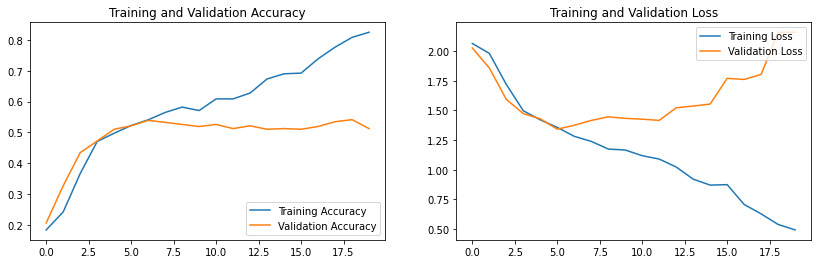

In [ ]:
history= history1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

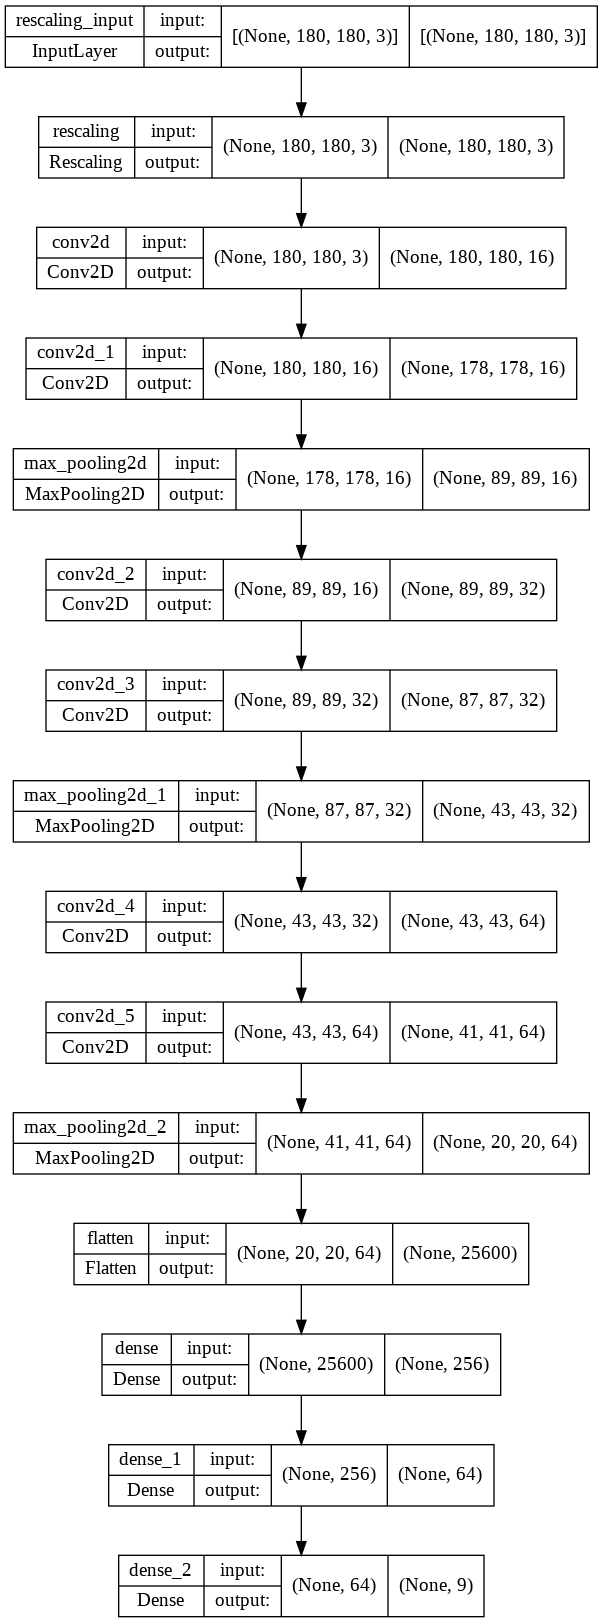

In [ ]:
# plotting the model layers 
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# def pri_evaluate_both(score_train, score_val):
#   print(f"train accuracy{score_train[1]} \n train loss{score_train[0]}")
#   print(f"validation  accuracy{score_val[1]} \n validation loss{score_val[0]}")


In [ ]:
print("Printing train loss and accuracy")
score1_train = model1.evaluate(train_ds, verbose=1)
print("Printing validation loss and accuracy")
score1_val = model1.evaluate(val_ds, verbose=1)
print("Printing test loss and accuracy")
score1_test = model1.evaluate(test_ds)

Printing train loss and accuracy
56/56 [==============================] - 2s 38ms/step - loss: 0.4854 - accuracy: 0.8259 - mse: 18.1464
Printing validation loss and accuracy
14/14 [==============================] - 1s 36ms/step - loss: 2.1593 - accuracy: 0.5123 - mse: 18.5125
Printing test loss and accuracy
1/1 [==============================] - 25s 25s/step - loss: 3.9171 - accuracy: 0.3475 - mse: 15.9778


#### Here we can see that after reaching the 7th epoch, the model starts overfitting, where the training accuracy significantly increases and the test decreases. 

### This is the cause because we didnt add Dropout and BatchNormalization() 
**We can see that:**
- The final train accuracy is 0.8259
- Validation accuracy is 0.5123
- The test accuracy is 0.3475


## Model 2: with BatchNormalization() and Dropout()

In [ ]:

def model2():
  # create model
  model = Sequential()
  model.add(Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))

  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.20))
  
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
    
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.30))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.40))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.30))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.30))
  model.add(Dense(num_classes, activation='softmax'))

  return model


In [ ]:
#creating model2
model2 = model2()

In [ ]:
# View the summary of all layers
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_42 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 178, 178, 16)      2320      
                                                                 
 batch_normalization_43 (Bat  (None, 178, 178, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 16)      

In [ ]:
# Compile model
model2.compile(adam_v2.Adam(learning_rate = 0.0001), loss='SparseCategoricalCrossentropy', metrics=['accuracy', 'mse'])

### Train the model

In [ ]:
epochs = 21
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/21
56/56 [==============================] - 9s 137ms/step - loss: 2.6911 - accuracy: 0.1847 - mse: 18.0989 - val_loss: 2.2412 - val_accuracy: 0.0761 - val_mse: 18.4521
Epoch 2/21
56/56 [==============================] - 7s 124ms/step - loss: 2.1003 - accuracy: 0.2478 - mse: 18.0884 - val_loss: 2.2759 - val_accuracy: 0.1499 - val_mse: 18.4569
Epoch 3/21
56/56 [==============================] - 7s 122ms/step - loss: 2.0096 - accuracy: 0.2790 - mse: 18.0892 - val_loss: 2.6092 - val_accuracy: 0.1499 - val_mse: 18.4737
Epoch 4/21
56/56 [==============================] - 7s 126ms/step - loss: 1.9846 - accuracy: 0.2946 - mse: 18.0902 - val_loss: 2.8035 - val_accuracy: 0.1790 - val_mse: 18.4826
Epoch 5/21
56/56 [==============================] - 7s 127ms/step - loss: 1.9097 - accuracy: 0.3265 - mse: 18.0929 - val_loss: 3.0098 - val_accuracy: 0.2461 - val_mse: 18.4891
Epoch 6/21
56/56 [==============================] - 7s 125ms/step - loss: 1.8929 - accuracy: 0.3198 - mse: 18.0924 - val

### Visualizing training results

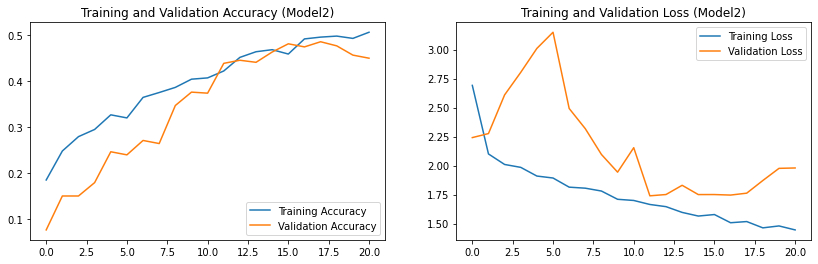

In [ ]:
history = history2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model2)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model2)')
plt.show()

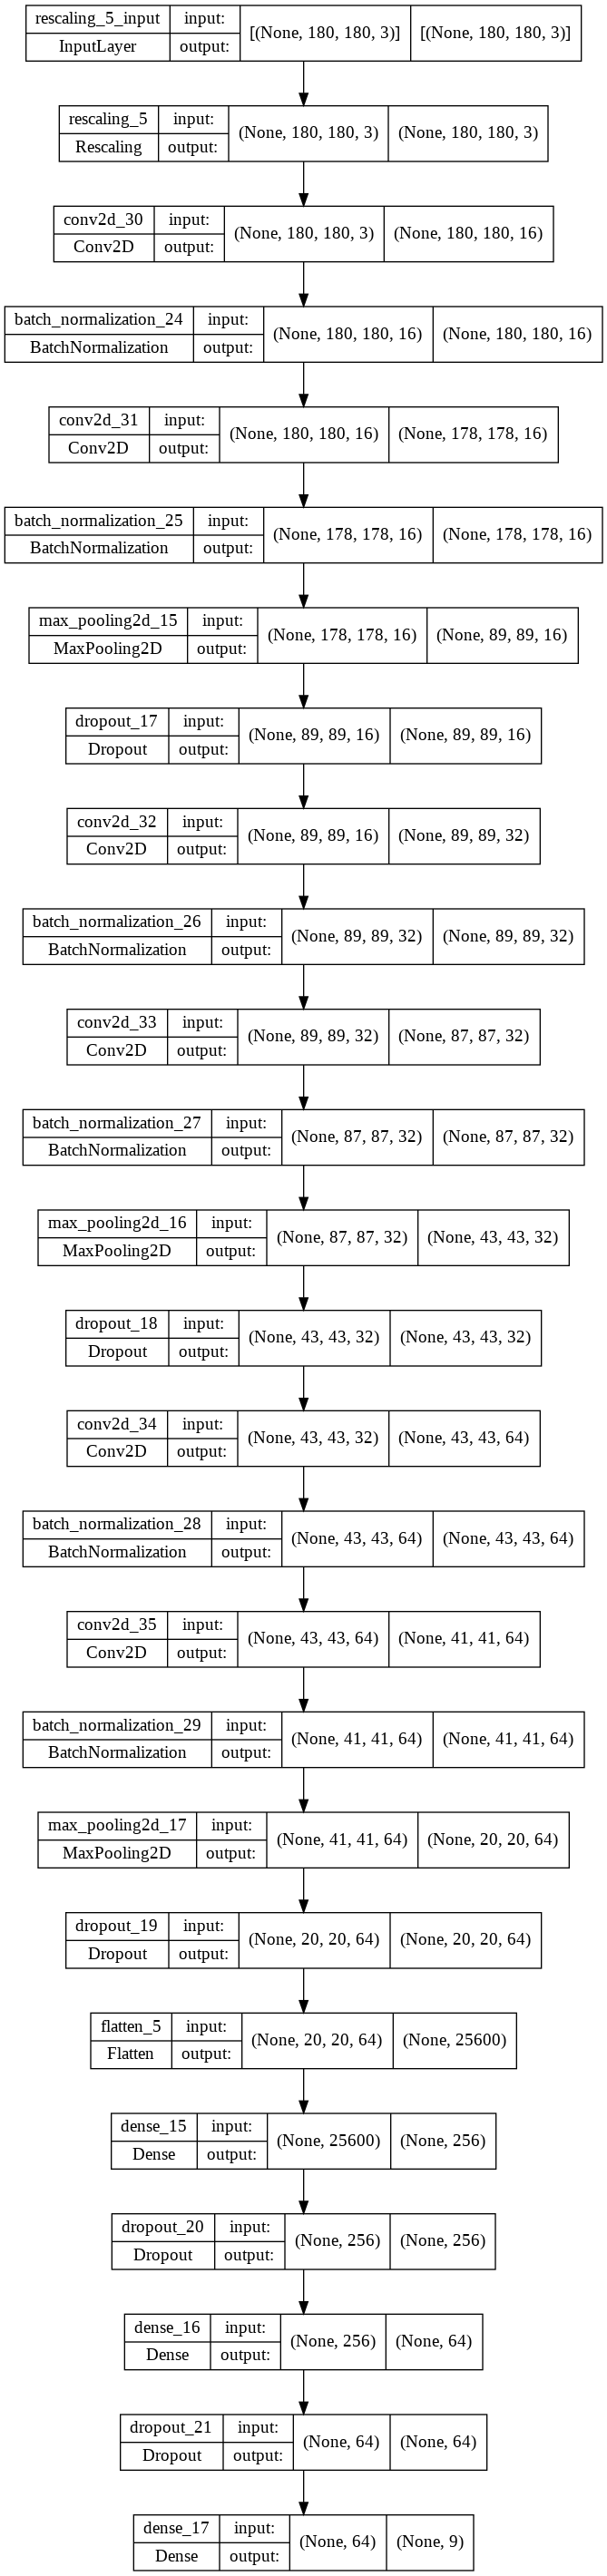

In [ ]:
# plotting the model layers 
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print("Printing train loss and accuracy")
score1_train = model2.evaluate(train_ds, verbose=1)
print("Printing validation loss and accuracy")
score1_val = model2.evaluate(val_ds, verbose=1)
print("Printing test loss and accuracy")
score1_test = model2.evaluate(test_ds)

Printing train loss and accuracy
56/56 [==============================] - 2s 38ms/step - loss: 1.7023 - accuracy: 0.4927 - mse: 18.1294
Printing validation loss and accuracy
14/14 [==============================] - 1s 35ms/step - loss: 1.9794 - accuracy: 0.4497 - mse: 18.5034
Printing test loss and accuracy
1/1 [==============================] - 4s 4s/step - loss: 3.1773 - accuracy: 0.3136 - mse: 15.9680


#### Now the model looks good but the accuracy is really low.

### This is the cause because we don't have much variety of data, and we have fewer data. So we should augment the dataset.
**We can see that:**
- The final train accuracy is 0.4927 
- Validation accuracy is 0.4497
- The test accuracy is 0.3136


#### For the next model we can augment the images and see how much it can improve. 

## Model 3: Augmenting data

In [ ]:
# creating keras augment varaiable
data_aug = Sequential([
                      layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical", input_shape=(img_height,img_width,3)),
                    #  layers.experimental.preprocessing.RandomTranslation(height_factor=(0.3, 0.3), width_factor=(0.3, 0.3), fill_mode="reflect", interpolation="bilinear",),
                      layers.experimental.preprocessing.RandomRotation(factor=0.2, fill_mode='reflect'),
                      layers.experimental.preprocessing.RandomZoom(height_factor=(0.3, 0.3), width_factor=(0.3, 0.3), fill_mode='reflect')
])

## Visulizing Augumentation data 

['actinic keratosis', 'melanoma', 'pigmented benign keratosis', 'basal cell carcinoma', 'nevus', 'squamous cell carcinoma', 'seborrheic keratosis', 'vascular lesion', 'dermatofibroma']


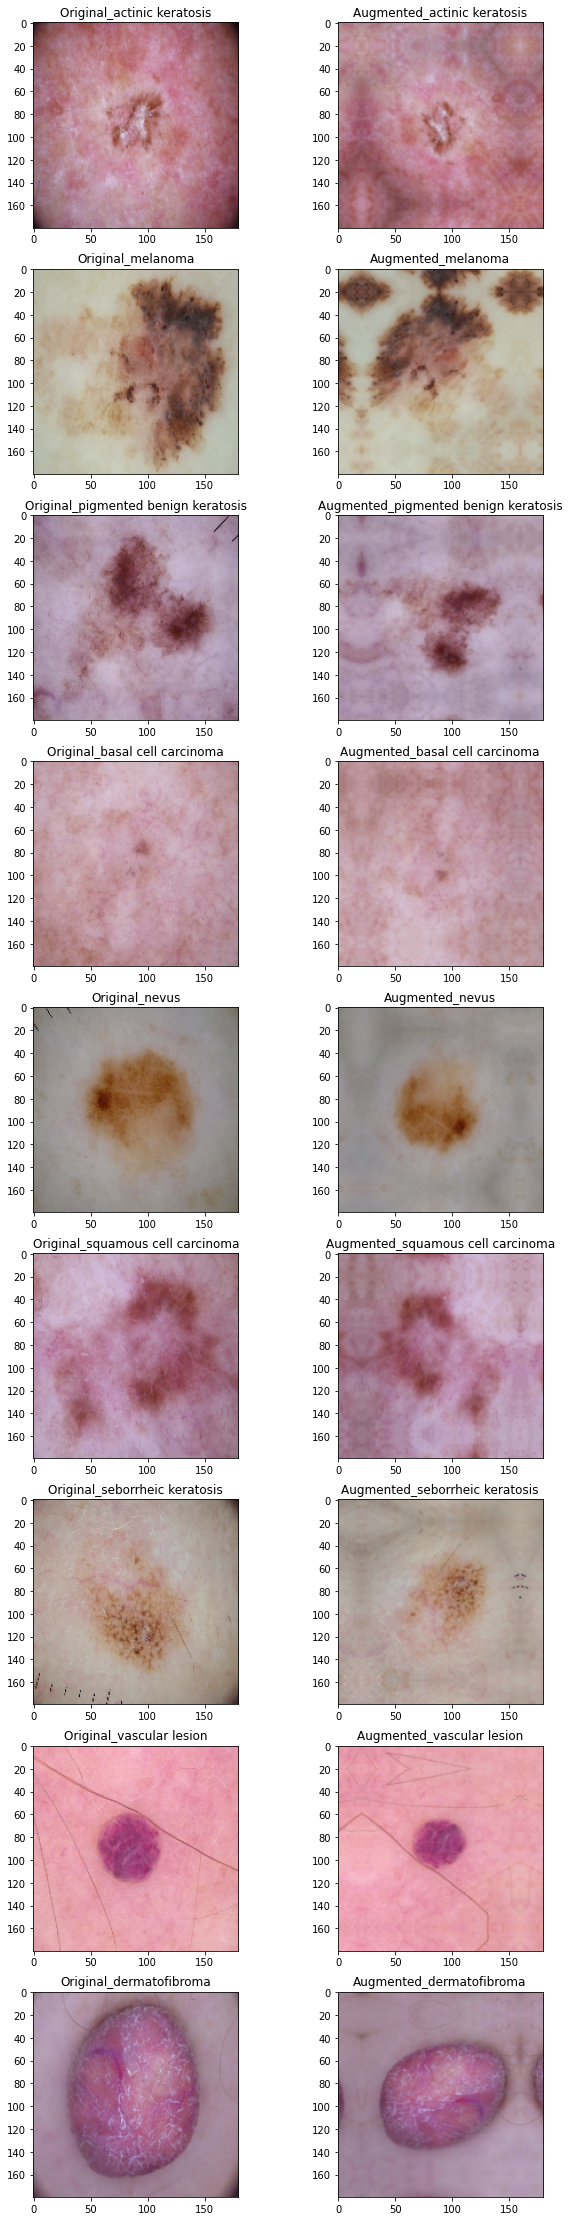

In [ ]:
visited = []
visited_all = False
plot_idx = 0
num_classes = len(class_names)
plt.figure(figsize=(10,40))

for image, label in train_ds.take(20):
  if visited_all:
    print(visited)
    break
  for i in range(num_classes):
    if len(visited) == num_classes:
      visited_all = True
      break

    if class_names[label[i]] in visited:
      continue
    else:
      plt.subplot(num_classes,2,plot_idx+1)
      plt.imshow(image[i].numpy().astype("uint8"))
      plt.title("Original_"+class_names[label[i]])
      plot_idx+=1

      plt.subplot(num_classes,2,plot_idx+1)
      aug_img=data_aug(image)
      plt.imshow(aug_img[i].numpy().astype("uint8"))
      plt.title("Augmented_"+class_names[label[i]])
      plot_idx+=1

      visited.append(class_names[label[i]])

### We can see that each image is augmented, the left is the original, and the right is the augmented image. And you can see the difference. 

### Defining model 3

In [ ]:
def model3():
  # create model
  # model = Sequential()
  # model.add(data_aug)
  # model.add(Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))

  # model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Conv2D(16, (3, 3), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Conv2D(32, (3, 3), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.20))
    
  # model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Conv2D(64, (3, 3), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.40))

  # model.add(Flatten())
  # model.add(Dense(256, activation='relu'))
  # model.add(Dropout(0.25))
  # model.add(Dense(64, activation='relu'))
  # model.add(Dropout(0.25))
  # model.add(Dense(num_classes, activation='softmax'))

  
  model = Sequential()
  model.add(data_aug)
  model.add(Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))

  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.20))
  
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
    
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.30))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.40))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.30))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.30))
  model.add(Dense(num_classes, activation='softmax'))

  return model


In [ ]:
#creating model3
model3 = model3()

In [ ]:
# View the summary of all layers
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 16)     64        
 hNormalization)                                      

In [ ]:
# Compile model
model3.compile(adam_v2.Adam(learning_rate = 0.0001), loss='SparseCategoricalCrossentropy', metrics=['accuracy', 'mse'])

### Train the model

In [ ]:
epochs = 21
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/21
56/56 [==============================] - 63s 933ms/step - loss: 2.8045 - accuracy: 0.1479 - mse: 18.0985 - val_loss: 2.6947 - val_accuracy: 0.0492 - val_mse: 18.4577
Epoch 2/21
56/56 [==============================] - 8s 137ms/step - loss: 2.1878 - accuracy: 0.2098 - mse: 18.0871 - val_loss: 2.8372 - val_accuracy: 0.0582 - val_mse: 18.4586
Epoch 3/21
56/56 [==============================] - 8s 137ms/step - loss: 2.0668 - accuracy: 0.2422 - mse: 18.0885 - val_loss: 2.9039 - val_accuracy: 0.1499 - val_mse: 18.4645
Epoch 4/21
56/56 [==============================] - 8s 136ms/step - loss: 1.9823 - accuracy: 0.2779 - mse: 18.0899 - val_loss: 2.9089 - val_accuracy: 0.1655 - val_mse: 18.4686
Epoch 5/21
56/56 [==============================] - 8s 135ms/step - loss: 1.9463 - accuracy: 0.2768 - mse: 18.0902 - val_loss: 2.6245 - val_accuracy: 0.2416 - val_mse: 18.4659
Epoch 6/21
56/56 [==============================] - 8s 136ms/step - loss: 1.9065 - accuracy: 0.3231 - mse: 18.0927 - va

### Visualizing training results

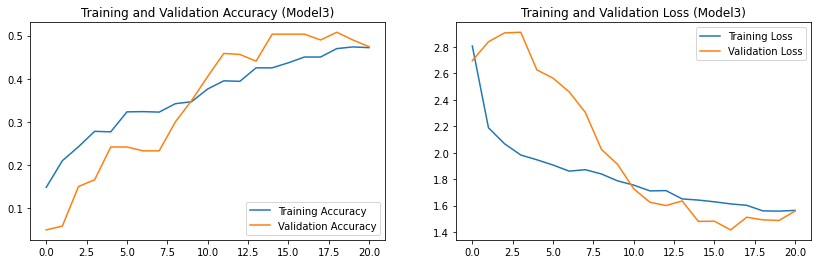

In [ ]:
history = history3
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model3)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model3)')
plt.show()

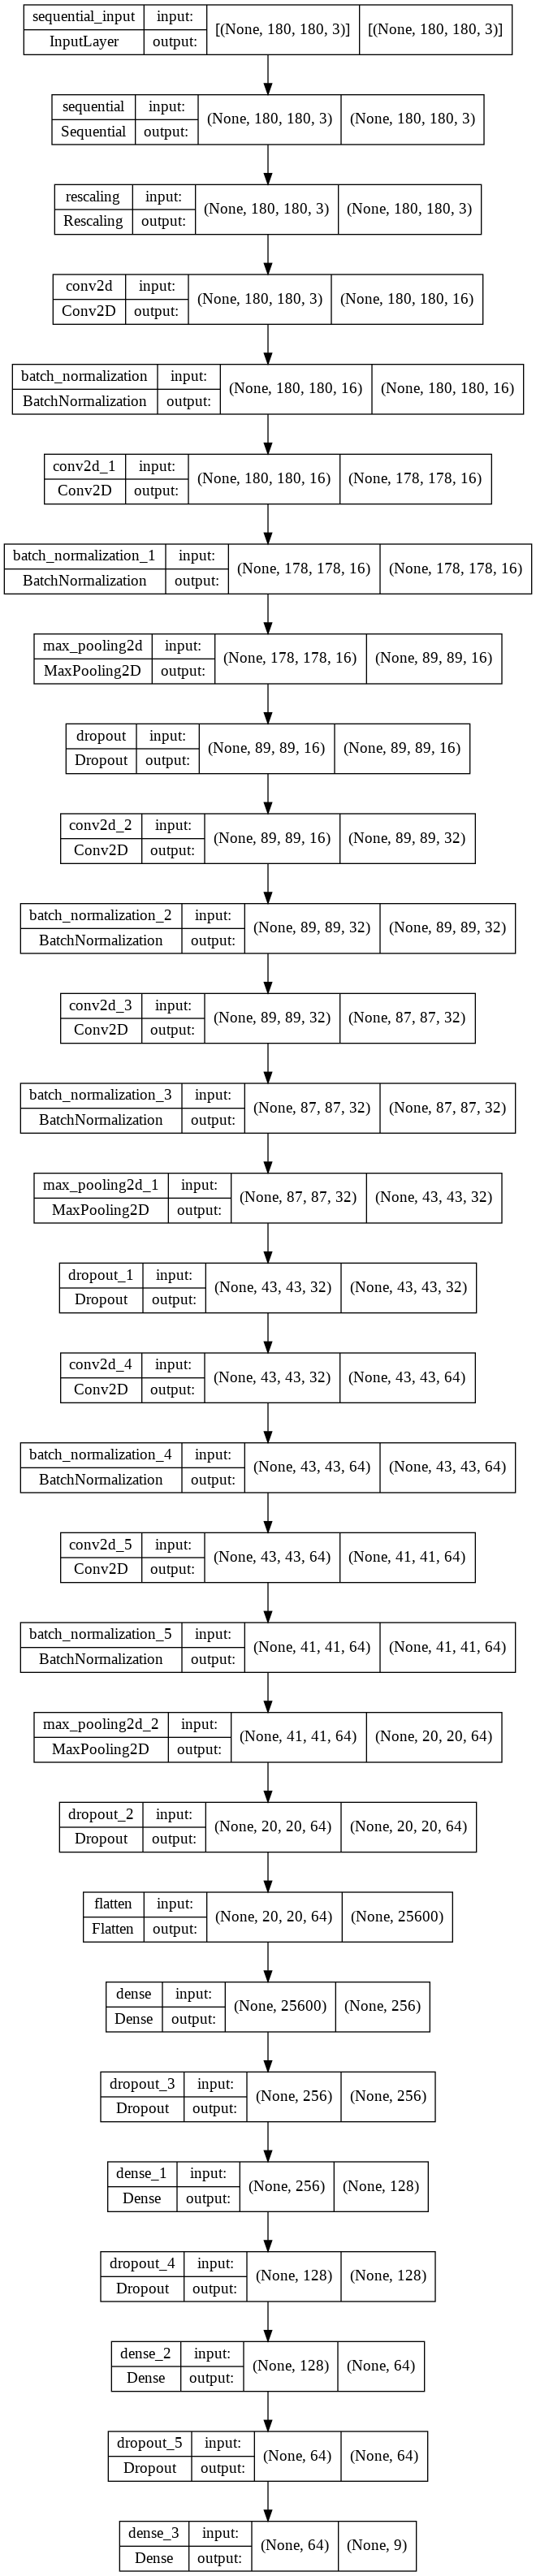

In [ ]:
# plotting the model layers 
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print("Printing train loss and accuracy")
score1_train = model3.evaluate(train_ds, verbose=1)
print("Printing validation loss and accuracy")
score1_val = model3.evaluate(val_ds, verbose=1)
print("Printing test loss and accuracy")
score1_test = model3.evaluate(test_ds)

Printing train loss and accuracy
56/56 [==============================] - 2s 36ms/step - loss: 1.5030 - accuracy: 0.5011 - mse: 18.1140
Printing validation loss and accuracy
14/14 [==============================] - 1s 36ms/step - loss: 1.5594 - accuracy: 0.4743 - mse: 18.4859
Printing test loss and accuracy
1/1 [==============================] - 23s 23s/step - loss: 2.2173 - accuracy: 0.3220 - mse: 15.9495


#### Now the model looks good and overfitting is resolved. However, the accuracy is really low.

#### This is the cause because we don't have much variety of data, and we have fewer data. So we should create more samples for each class to make it less imbalance. 
**We can see that:**
- The final train accuracy is 0.5011  
- Validation accuracy is 0.4743 
- The test accuracy is 0.3220

### Compare to the 2nd model, we got better result using Augumentation and preprocessing the image.

#### For the next model we can augment the images and see how much it can improve. 
- So, we need to rectify the class imbalance.
- And add some more images so we can get better accuracy. 






*******************
*******************
*******************
*******************

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
class_count = []
for i in class_names:
  class_path = pathlib.Path(main_path + "/Train" + "/"+  i)
  count = len(list(class_path.glob('*.jpg')))
  class_count.append(count)

print(class_names, "\n", class_count)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 
 [114, 376, 95, 438, 357, 462, 77, 181, 139]


In [ ]:
class_data = {"Class Names" : class_names, "Class Count" : class_count}
df_class = pd.DataFrame(class_data)
print(df_class)

                  Class Names  Class Count
0           actinic keratosis          114
1        basal cell carcinoma          376
2              dermatofibroma           95
3                    melanoma          438
4                       nevus          357
5  pigmented benign keratosis          462
6        seborrheic keratosis           77
7     squamous cell carcinoma          181
8             vascular lesion          139


## Plotting each class counts using bar graph.

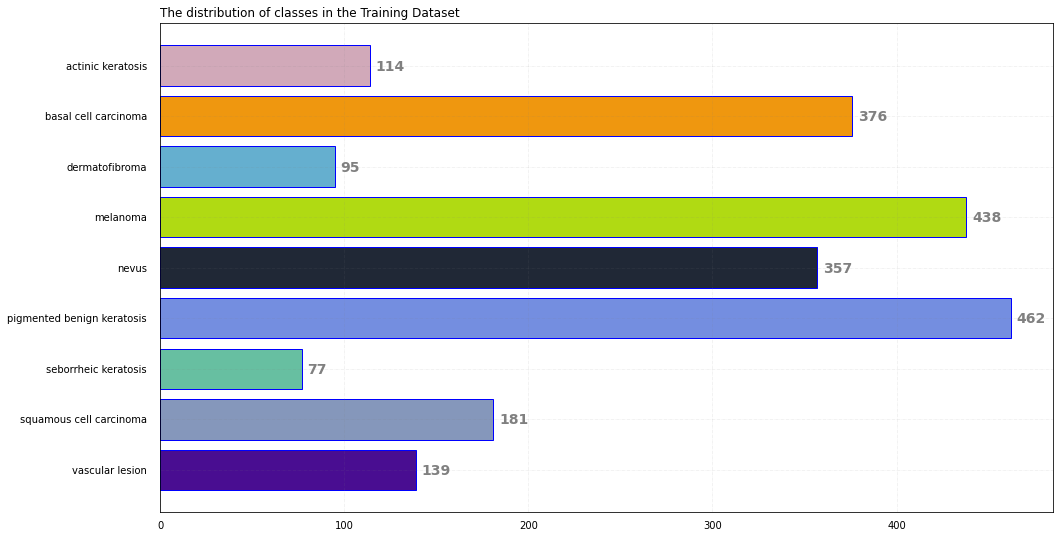

In [ ]:
class_colr = ["#d1a9b9", "#ef970f", "#65afcf", "#b0da13", "#202836", "#748ee0", "#67bfa1", "#8597bb", "#490d91"]

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(class_names, class_count, color = class_colr, edgecolor='blue')
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(True)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+3, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 14, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('The distribution of classes in the Training Dataset',
             loc ='left', )
size=20
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': 25,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': 25*0.75,
          'axes.titlepad': 15}
plt.rcParams.update(params)


# Show Plot
plt.show()

# source: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

### Some insights:
- Basal cell carcinoma(95) and Seborrheic keratosis(77) have the least samples.
- Pigmented benign keratosis(462) and Melanoma(438) have the most samples.
- Actinic keratosis(114), Squamous cell carcinoma(181), Vascular lesion(139), Basal cell carcinoma(95), and Seborrheic keratosis(77) have samples less than **40%** compared to **most samples classes**( Pigmented benign keratosis-462). 

#### Because of imbalance classes, we are getting lousy accuracy and model being biased towards the most sample classes. 
- So, we need to rectify the class imbalance.
- And add some more images so we can get better accuracy. 

*******************
*******************
*******************

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
# !pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + i)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [5]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# from glob import glob

In [ ]:
# path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [ ]:
# lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [ ]:
# dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
# df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [ ]:
# new_df['Label'].value_counts()

In [11]:
class_count = []

for i in class_names:
  class_path = pathlib.Path(main_path + "/Train" + "/"+  i)
  count = len(list(class_path.glob('*/*.jpg')))
  class_count.append(count)

print(class_names, "\n", class_count)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 
 [500, 500, 500, 500, 500, 500, 500, 500, 500]


In [12]:
class_data = {"Class Names" : class_names, "Class Count" : class_count}
df_class = pd.DataFrame(class_data)
print(df_class)

                  Class Names  Class Count
0           actinic keratosis          500
1        basal cell carcinoma          500
2              dermatofibroma          500
3                    melanoma          500
4                       nevus          500
5  pigmented benign keratosis          500
6        seborrheic keratosis          500
7     squamous cell carcinoma          500
8             vascular lesion          500


### now we can see that we have added 500 images to each class.

In [19]:
class_count = []

for i in class_names:
  class_path = pathlib.Path(main_path + "/Train" + "/"+  i)
  count = len(list(class_path.glob('**/*.jpg')))
  class_count.append(count)

print(class_names, "\n", class_count)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 
 [614, 876, 595, 938, 857, 962, 577, 681, 639]


In [20]:
class_data = {"Class Names" : class_names, "Class Count" : class_count}
df_class = pd.DataFrame(class_data)
print(df_class)

                  Class Names  Class Count
0           actinic keratosis          614
1        basal cell carcinoma          876
2              dermatofibroma          595
3                    melanoma          938
4                       nevus          857
5  pigmented benign keratosis          962
6        seborrheic keratosis          577
7     squamous cell carcinoma          681
8             vascular lesion          639


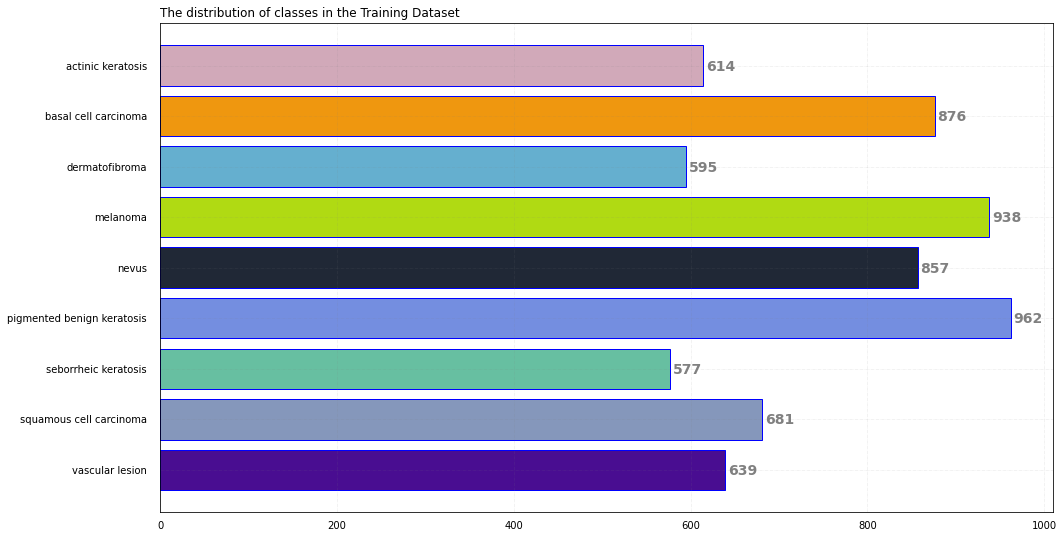

In [21]:
class_colr = ["#d1a9b9", "#ef970f", "#65afcf", "#b0da13", "#202836", "#748ee0", "#67bfa1", "#8597bb", "#490d91"]

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(class_names, class_count, color = class_colr, edgecolor='blue')
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(True)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+3, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 14, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('The distribution of classes in the Training Dataset',
             loc ='left', )
size=20
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': 25,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': 25*0.75,
          'axes.titlepad': 15}
plt.rcParams.update(params)


# Show Plot
plt.show()

# source: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

### Here, we can see that classes are not too imbalanced, and we can move with this sample counts for each class. And the ratio of imbalance is not high. 

In [13]:
main_path = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration"

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [14]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [15]:
data_dir_train_new = pathlib.Path(main_path + "/Train")

# data_dir_train_new= data_dir_train.glob('*/output/*.jpg')
new_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_new,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [16]:
new_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_new,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [17]:
## for test set , creating only 1 batch
data_dir_test_new = pathlib.Path(main_path + "/Test")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test_new,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [18]:
class_names = new_train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Model 4

In [ ]:
def model4():
  # create model
  model = Sequential()
  model.add(Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))

  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
    
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.40))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.30))
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [ ]:
### creating final model
model4 = model4()

In [ ]:
# View the summary of all layers
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_16 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 16)      2320      
                                                                 
 batch_normalization_17 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)      

In [ ]:
# Compile model
model4.compile(adam_v2.Adam(learning_rate = 0.0001), loss='SparseCategoricalCrossentropy', metrics=['accuracy', 'mse'])

### Train the model

In [ ]:
epochs = 50
history4 = model4.fit(
  new_train_ds,
  validation_data=new_val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 47s 257ms/step - loss: 2.2855 - accuracy: 0.1855 - mse: 20.5435 - val_loss: 2.2795 - val_accuracy: 0.1002 - val_mse: 20.7804
Epoch 2/50
169/169 [==============================] - 50s 288ms/step - loss: 1.9331 - accuracy: 0.2723 - mse: 20.5460 - val_loss: 2.2444 - val_accuracy: 0.1448 - val_mse: 20.7826
Epoch 3/50
169/169 [==============================] - 44s 256ms/step - loss: 1.8176 - accuracy: 0.3073 - mse: 20.5492 - val_loss: 1.9891 - val_accuracy: 0.2866 - val_mse: 20.7924
Epoch 4/50
169/169 [==============================] - 44s 253ms/step - loss: 1.7210 - accuracy: 0.3509 - mse: 20.5515 - val_loss: 1.5676 - val_accuracy: 0.3898 - val_mse: 20.7971
Epoch 5/50
169/169 [==============================] - 45s 257ms/step - loss: 1.6427 - accuracy: 0.3846 - mse: 20.5545 - val_loss: 1.5166 - val_accuracy: 0.4380 - val_mse: 20.8018
Epoch 6/50
169/169 [==============================] - 44s 254ms/step - loss: 1.5731 - accuracy: 0.3993 - 

### Visualizing training results

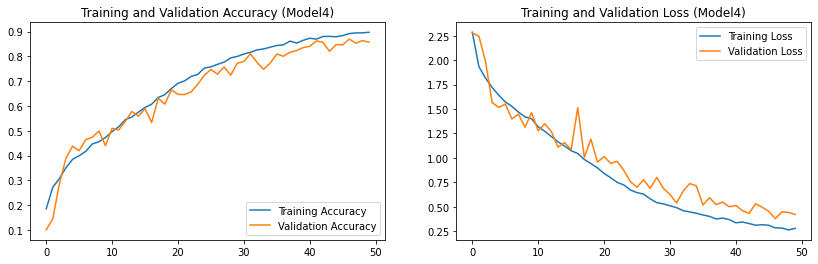

In [ ]:
history = history4
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model4)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model4)')
plt.show()

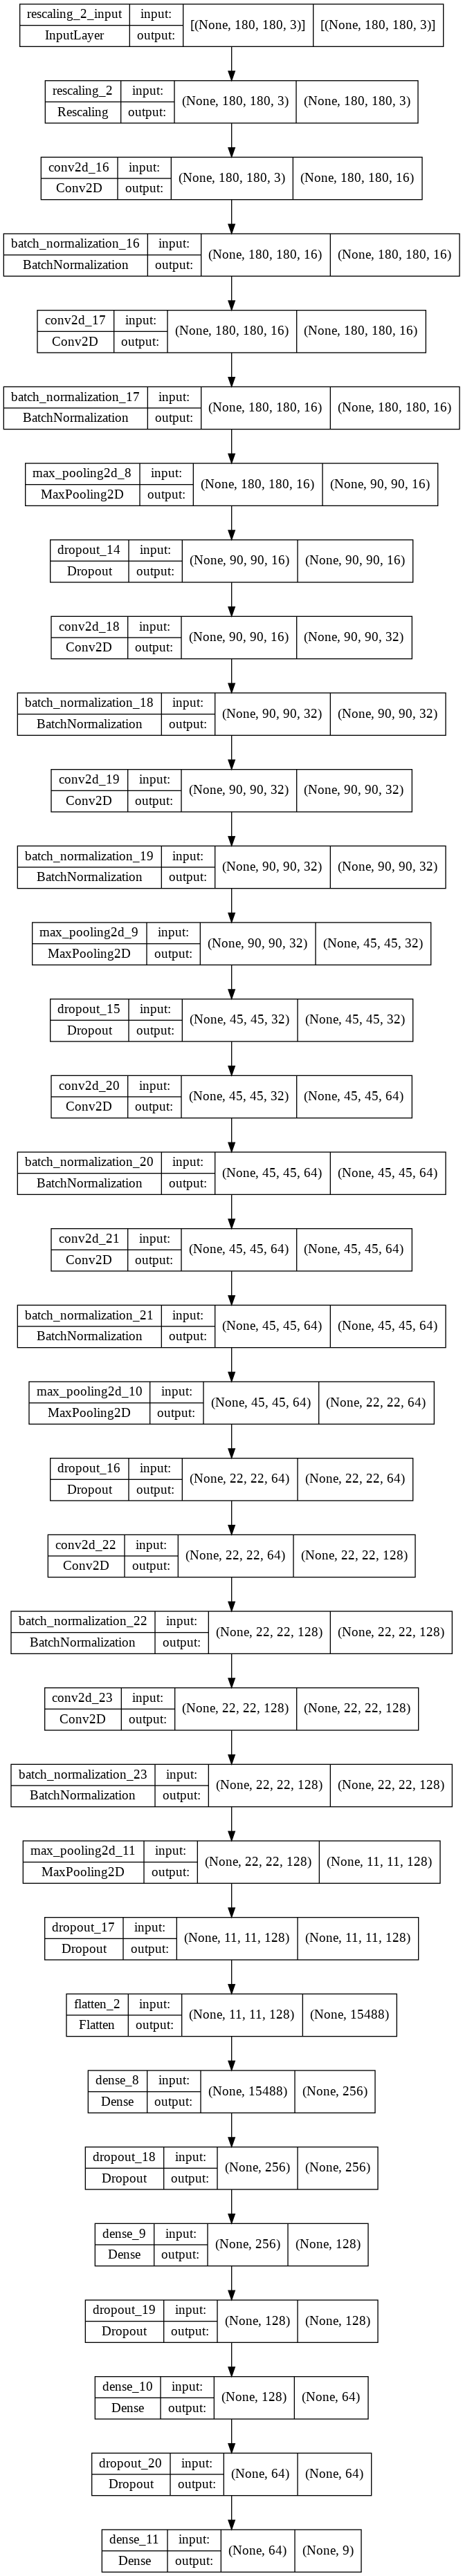

In [ ]:
plot_model(model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print("Printing train loss and accuracy")
score1_train = model4.evaluate(new_train_ds, verbose=1)
print("Printing validation loss and accuracy")
score1_val = model4.evaluate(new_val_ds, verbose=1)
print("Printing test loss and accuracy")
score1_test = model4.evaluate(test_ds)

Printing train loss and accuracy
169/169 [==============================] - 31s 178ms/step - loss: 0.1709 - accuracy: 0.9343 - mse: 20.6188
Printing validation loss and accuracy
43/43 [==============================] - 8s 152ms/step - loss: 0.4219 - accuracy: 0.8567 - mse: 20.8597
Printing test loss and accuracy
1/1 [==============================] - 4s 4s/step - loss: 3.6058 - accuracy: 0.4746 - mse: 15.9923


#### Now the model looks good and even the accuracy is ok and model didn't overfit.

#### We can still improve the accuracy, but we need more data. As of now, we have really less data, and even we can augment more data. Here we created only 500 images for each class; in the future, we can create more like 1.5k+.
**Final model accuracy:**
- The final train accuracy is 0.9343
- Validation accuracy is 0.8567
- The test accuracy is 0.4746


### So using augmentation, rebalance, dropout, and batch norm helped reduce the overfitting and improved the model accuracy. 

